# **Import Dependencies**

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import scipy.sparse as sp
from sklearn.preprocessing import OneHotEncoder

# **The Dataset**

# **Load Data**

In [2]:
data = pd.read_csv(
    'data.txt',
    sep="\t",
    na_values=[""],
    low_memory=False,
    parse_dates=['Time', "Problem Start Time"]
)

print(data.head())
print(data.shape)


   Row Sample Name                    Transaction Id Anon Student Id  \
0    1    All Data  f48cba2510087c502dde920d948b364b            S002   
1    2    All Data  2e2674c362ab346b56735759d7754b7f            S002   
2    3    All Data  7f7d2e12b4cc5fc53472d390b21dd624            S002   
3    4    All Data  978a103b1e84307bacd12fb88606f857            S002   
4    5    All Data  831b85657c909543fff48c06c076eac2            S002   

   Session Id                Time  Time Zone Duration (sec)  \
0           1 2016-02-05 19:46:00        NaN              0   
1           1 2016-02-05 19:46:00        NaN              0   
2           1 2016-02-05 19:46:00        NaN              0   
3           1 2016-02-05 19:46:00        NaN              0   
4           1 2016-02-05 19:46:00        NaN              0   

  Student Response Type  Student Response Subtype  ...  \
0               ATTEMPT                       NaN  ...   
1               ATTEMPT                       NaN  ...   
2             

# **Data Visualisations**

In [3]:
print(data.columns)
print(f"No. Rows : {data.shape[0]}")
print(f"No. Cols : {data.shape[1]}")


Index(['Row', 'Sample Name', 'Transaction Id', 'Anon Student Id', 'Session Id',
       'Time', 'Time Zone', 'Duration (sec)', 'Student Response Type',
       'Student Response Subtype', 'Tutor Response Type',
       'Tutor Response Subtype', 'Level (Default)', 'Problem Name',
       'Problem View', 'Problem Start Time', 'Step Name', 'Attempt At Step',
       'Is Last Attempt', 'Outcome', 'Selection', 'Action', 'Input',
       'Feedback Text', 'Feedback Classification', 'Help Level',
       'Total Num Hints', 'Condition Name', 'Condition Type',
       'Condition Name.1', 'Condition Type.1', 'KC (Tokens)',
       'KC Category (Tokens)', 'KC (Single-KC)', 'KC Category (Single-KC)',
       'KC (Unique-step)', 'KC Category (Unique-step)', 'KC (Tokens_Fewer)',
       'KC Category (Tokens_Fewer)', 'KC (Tokens_more)',
       'KC Category (Tokens_more)', 'KC (Operations)',
       'KC Category (Operations)', 'KC (Operation 2)',
       'KC Category (Operation 2)', 'School', 'Class', 'Event Type']

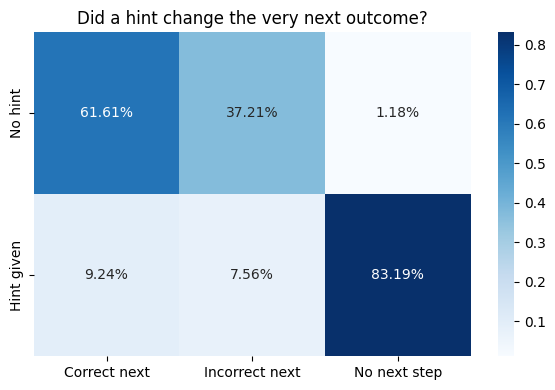

In [4]:
# ensure correct temporal order
data = data.sort_values(["Anon Student Id", "Time"]).copy()

# add next row outcome within each student sequence
data["next_outcome"] = data.groupby("Anon Student Id")["Outcome"].shift(-1)

# categorise outcomes
def bucket(x: str) -> str:
    x = str(x).lower()
    if x == "correct":
        return "next_correct"
    elif x == "incorrect":
        return "next_incorrect"
    else:
        return "no_next_attempt"

data["next_cat"] = data["next_outcome"].map(bucket)

# binary hint flag
data["hint"] = data["Outcome"].str.lower().eq("hint").astype(int)

# contingency table  (rows = hint vs no hint, cols = next outcome class)
heat_df = pd.crosstab(data["hint"], data["next_cat"], normalize="index")

plt.figure(figsize=(6, 4))
sns.heatmap(
    heat_df,
    annot=True, fmt=".2%", cmap="Blues",
    xticklabels=["Correct next", "Incorrect next", "No next step"],
    yticklabels=["No hint", "Hint given"]
)
plt.title("Did a hint change the very next outcome?")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.show()


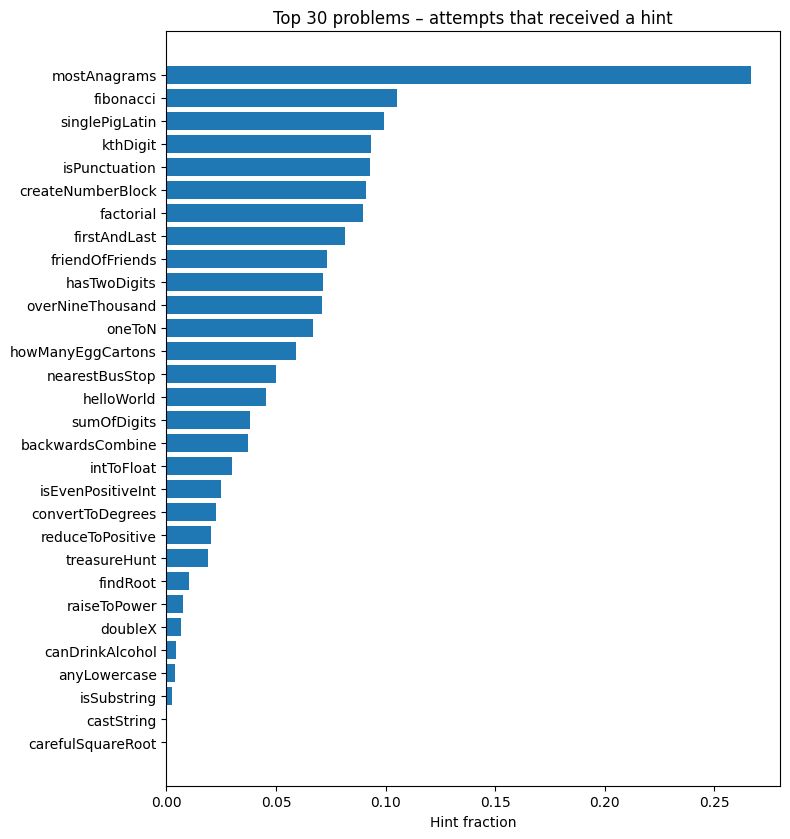

In [5]:
N = 30  # show top 30
hint_rate = (
    data.groupby("Problem Name")["hint"]
    .mean()
    .sort_values(ascending=False)
    .head(N)
)

plt.figure(figsize=(8, 0.25*N + 1))
plt.barh(hint_rate.index[::-1], hint_rate.values[::-1])
plt.gca().set_xlabel("Hint fraction")
plt.title(f"Top {N} problems – attempts that received a hint")
plt.tight_layout()
plt.show()

# **Preprocessing**

In [6]:
# We need to organise the data into states, actions and rewards for RL

# action - hint or no hint ?

actions = data['hint'].to_numpy()
action_dim = len(actions.shape)


# first estimate question difficulty by getting the mean correctness
p_correct = (
    data.groupby("Problem Name")["Outcome"]
    .apply(lambda x: (x.str.lower() == 'correct').mean())
)

# stop the divide by 0 errors
epsilon = 1e-6
beta = np.log((1 - p_correct + epsilon) / (p_correct + epsilon))

# add beta to dataframe
data['beta'] = data['Problem Name'].map(beta)

# 1-B Elo update
learning_rate = 0.05
data['Elo'] = 0.0 # cumulative Elo score
data['Reward'] = 0.0 # Elo reward for that step


# for every student's atempt history compute elo reward then add up cumulative
# score at each step + append to dataframe

for student, history in data.groupby('Anon Student Id'):
  elo = 0.0
  for i, row in history.sort_values('Time').iterrows():
    outcome = str(row['Outcome']).lower()
    if outcome in ('correct', 'incorrect'):
      p = 1 / (1 + np.exp(-(elo - row['beta'])))
      elo_new = elo + learning_rate * ((outcome == 'correct') - p)

      data.at[i, 'Reward'] = elo_new - elo
      elo = elo_new
    data.at[i, "Elo"] = elo



# check editied columns + mean, std elo reward
print(data[["Anon Student Id", "Problem Name", "Outcome", "Elo", "Reward"]].head())
print("Reward mean:", data['Reward'].mean().round(4))
print("Reward std:", data['Reward'].std())


  Anon Student Id    Problem Name    Outcome       Elo    Reward
0            S002  nearestBusStop    CORRECT  0.023411  0.023411
1            S002  nearestBusStop  INCORRECT -0.003468 -0.026880
2            S002  nearestBusStop    CORRECT  0.019986  0.023455
3            S002  nearestBusStop    CORRECT  0.043149  0.023163
4            S002  nearestBusStop    CORRECT  0.066024  0.022875
Reward mean: 0.0003
Reward std: 0.020603985572324367


In [7]:
# add time since previous attempt (estimated thinking time)
# add cumulative hints / session
# terminal column (bool)

data = data.sort_values(['Anon Student Id', 'Time']).copy()

data['time_gap'] = (
    data.groupby('Anon Student Id')['Time']
    .diff().dt.total_seconds()
    .fillna(0)
)

data['hints_so_far'] = (
    data.groupby('Anon Student Id')['hint']
      .cumsum().shift(fill_value=0)
)

# terminals

terminals = data.groupby('Anon Student Id').tail(1).index
data['terminal'] = False
data.loc[terminals, 'terminal'] = True



# train / test split (80/20)

np.random.seed(42)
students = data['Anon Student Id'].unique()
test = np.random.choice(students, size=int(0.2 * len(students)), replace=False)

data['is_test'] = data['Anon Student Id'].isin(test)


one_hot = OneHotEncoder(handle_unknown='ignore')
oh_features = one_hot.fit_transform(data[['Problem Name']])

# mean time taken , std time taken
time_mu = data['time_gap'].mean()
time_sigma = data['time_gap'].std()

# mean hints, std hints
hint_mu = data['hints_so_far'].mean()
hint_sigma = data['hints_so_far'].std()



# as it stands reward is only calculated on attempt rows -> reward zero for all hint actions
# update data to propogate next step reward backward to reward network for hinting if it helped / penalise if not


is_attempt = data['Outcome'].str.lower().isin(['correct', 'incorrect'])
attempt_reward = data['Reward'].where(is_attempt)

data['reward_next_attempt'] = (
    attempt_reward.groupby(data['Anon Student Id']).shift(-1)
)

data['reward_next_attempt'] = data['reward_next_attempt'].fillna(0.0)




# **Hyperparameters**

In [9]:
buffer_size = 500_000  # Replay buffer size
batch_size = 256  # Batch size for all networks
cql_n_actions= 10  # Number of sampled actions
cql_importance_sample = True  # Use importance sampling
cql_target_action_gapt = -1.0  # Action gap
cql_tempt = 1.0  # CQL temperature
alpha = 1
lr = 3e-4
steps = 30_000
tau = 5e-3
gamma = 0.99
action_dim = 2


In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Base Network

In [120]:
class Network(nn.Module):
  def __init__(self, state_dim, action_dim=2):
    super().__init__()
    self.fc1 = nn.Linear(state_dim, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, action_dim)
    self.relu = nn.ReLU()

  def forward(self, x : torch.Tensor):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    return self.fc3(x)

In [121]:
n_transitions = 0
for i, history in data[~data['is_test']].groupby('Anon Student Id'):
  n_transitions += len(history) -1

print(n_transitions)
print(len(data))

21491
25498


# **Replay Buffer**

In [122]:
class ReplayBuffer():
  def __init__(self,
               state_dim : int,
               buffer_size : int):

    self.full = False
    self.ptr = 0
    self.buffer_size = buffer_size

    # set up to enable batches more skewed towards hint for balance
    self.hint_idx = []
    self.no_hint_idx = []

    self.states = np.zeros((buffer_size, state_dim), dtype=np.float32)

    self.actions = np.zeros(buffer_size, dtype=np.int64)

    self.rewards = np.zeros(buffer_size, dtype=np.float32)

    self.next_states = np.zeros((buffer_size, state_dim), dtype=np.float32)

    self.terminals = np.zeros(buffer_size, dtype=np.float32)


  def add(self, state, action, reward, next_state, terminal):
    i = self.ptr
    self.states[i] = state
    self.actions[i] = int(action)
    self.rewards[i] = float(reward)
    self.next_states[i] = next_state
    self.terminals[i] = float(terminal)

    # track hints and no hints
    if int(action) == 1:
      self.hint_idx.append(i)
    else:
      self.no_hint_idx.append(i)

    self.ptr += 1

    if self.ptr >= self.buffer_size:
      self.full = True
      self.ptr = self.buffer_size

  def sample(self, batch, oversample=False):
    max = self.buffer_size if self.full else self.ptr
    if not oversample :
      index = np.random.randint(0, max, size=batch)
    else:
      n_hint = int(batch * 0.3) # 70/30 split for balance
      n_no_hint = batch - n_hint
      hint_pool = self.hint_idx if len(self.hint_idx) else [0]
      no_hint_pool = self.no_hint_idx if len(self.no_hint_idx) else [0]
      index = np.concatenate([
          np.random.choice(hint_pool, size=min(n_hint, len(hint_pool)), replace=True),
          np.random.choice(no_hint_pool, size=min(n_no_hint, len(no_hint_pool)), replace=True),

      ])
      np.random.shuffle(index)


    return (
        torch.tensor(self.states[index], dtype=torch.float32),
        torch.tensor(self.actions[index], dtype=torch.long),
        torch.tensor(self.rewards[index], dtype=torch.float32),
        torch.tensor(self.next_states[index], dtype=torch.float32),
        torch.tensor(self.terminals[index], dtype=torch.float32),
    )



# **Agent**

In [123]:
class Agent():
  def __init__(self, replay_buffer, lr, batch_size, alpha, gamma, tau):
    self.lr = lr
    self.replay_buffer = replay_buffer
    self.batch_size = batch_size
    self.gamma = gamma
    self.alpha = alpha
    self.tau = tau
    self.device = device

    # plotting

    self.logevery = 500
    self._steps = []
    self.vals = []
    self.losses = []
    self.eval_states = None

    state_dim = self.replay_buffer.states.shape[1]
    self.q = Network(state_dim).to(device)
    self.target = Network(state_dim).to(device)
    self.target.load_state_dict(self.q.state_dict())

    self.optimiser = torch.optim.Adam(self.q.parameters(), lr=self.lr)
    self.loss = nn.MSELoss()

    theta_idx = state_dim - 3

  def update(self):
    for tp, p in zip(self.target.parameters(), self.q.parameters()):
      tp.data.mul_(1-self.tau).add_(self.tau * p.data)

  @torch.no_grad()
  def cache(self, step, loss_total):
    if self.eval_states is None or self.eval_states.numel() ==0:
      return
    q = self.q(self.eval_states)
    v = q.max(dim=1).values.mean().item()
    self._steps.append(int(step))
    self.vals.append(float(v))
    self.losses.append(float(loss_total))


  def prep_plot(self, buf, n_eval: int = 512):
    states= torch.as_tensor(buf.states, dtype=torch.float32, device=self.device)
    n = min(n_eval, states.shape[0])
    idx = torch.randperm(states.shape[0])[:n]
    self.eval_states = states.index_select(0, idx)

  def plot(self, label: str = None):
    x = np.array(self._steps, dtype=float)
    y = np.array(self.vals, dtype=float)
    loss = np.array(self.losses, dtype=float)

    name = label

    plt.figure(1, figsize=(8,5))
    plt.plot(x, y, label=name)
    plt.xlabel('Update Step')
    plt.ylabel('Training Curve')
    plt.legend()

    plt.figure(2, figsize=(8,5))
    plt.plot(x, loss, label=name)
    plt.xlabel('Update Step')
    plt.ylabel('Loss Curve')
    plt.legend()


  def train(self, max_steps, log_interval=500):

    self.q.load_state_dict(self.target.state_dict())
    for step in range(1, max_steps + 1):
      s,a,r,s2,t = self.replay_buffer.sample(self.batch_size, oversample=True)

      s = s.to(device).float()
      a = a.to(device).view(-1,1).long()
      r = r.to(device).view(-1,1).float()
      s2 = s2.to(device).float()
      t = t.to(device).view(-1,1).float()

      q_s = self.q(s)
      q_sa = q_s.gather(1, a)

      with torch.no_grad():
        q_next = self.target(s2)
        max_next = q_next.max(dim=1, keepdim=True).values
        y = r + self.gamma * (1-t) * max_next

      tdloss = self.loss(q_sa, y)

      lse_all = torch.logsumexp(q_s, dim=1, keepdim=True)

      # CQL penalty (conservativeness)
      lse = torch.logsumexp(q_s, dim=1, keepdim=True)
      cql_penalty = (lse - q_sa).mean()
      cql_gap = (lse_all - q_sa).mean()
      total_loss = tdloss + self.alpha * cql_penalty

      self.optimiser.zero_grad(set_to_none=True)
      total_loss.backward()
      nn.utils.clip_grad_norm_(self.q.parameters(), 5.0)
      self.optimiser.step()
      self.update()

      if (step + 1) % self.logevery == 0:
        self.cache(step +1, float(total_loss.item()))

      # if step % log_interval == 0:
      #   with torch.no_grad():
      #     avg_q_data = q_sa.mean().item()
      #     avg_q_all = q_s.mean().item()
      #   print(f"step : {step} | loss : {total_loss.item()} | Temporal Difference : {tdloss.item()}")
      #   print(f"CQL : {cql_penalty.item()} | Q(data) : {avg_q_data} | Q(all) : {avg_q_all}")
      #   print(f"CQL GAP : {cql_gap.item()}")


    return self.q






# **Populate Replay Buffer**

In [124]:
state_dim = (oh_features.shape[1] if not sp.issparse(oh_features) else oh_features.shape[1]) + 3
buf = ReplayBuffer(state_dim, n_transitions)



In [125]:
print(data.columns)

Index(['Row', 'Sample Name', 'Transaction Id', 'Anon Student Id', 'Session Id',
       'Time', 'Time Zone', 'Duration (sec)', 'Student Response Type',
       'Student Response Subtype', 'Tutor Response Type',
       'Tutor Response Subtype', 'Level (Default)', 'Problem Name',
       'Problem View', 'Problem Start Time', 'Step Name', 'Attempt At Step',
       'Is Last Attempt', 'Outcome', 'Selection', 'Action', 'Input',
       'Feedback Text', 'Feedback Classification', 'Help Level',
       'Total Num Hints', 'Condition Name', 'Condition Type',
       'Condition Name.1', 'Condition Type.1', 'KC (Tokens)',
       'KC Category (Tokens)', 'KC (Single-KC)', 'KC Category (Single-KC)',
       'KC (Unique-step)', 'KC Category (Unique-step)', 'KC (Tokens_Fewer)',
       'KC Category (Tokens_Fewer)', 'KC (Tokens_more)',
       'KC Category (Tokens_more)', 'KC (Operations)',
       'KC Category (Operations)', 'KC (Operation 2)',
       'KC Category (Operation 2)', 'School', 'Class', 'Event Type',

In [136]:


use_theta = False
use_timegap = True
use_hintcount = True



def encode_state(row_index: int) -> np.ndarray:
  ''' Helper function to encode states as 1D vector for NN '''



  if row_index in data.index:
    label_index = row_index
    pos_index = data.index.get_loc(row_index)
  elif isinstance(row_index, (int, np.integer)) and 0 <= int(row_index) < len(data):
    pos_index = int(row_index)

    label_index = data.index[pos_index]
  else:
    print('ERROR')

  if sp.issparse(oh_features):
    one_hot = oh_features[row_index].toarray().ravel().astype(np.float32)
  else:
    one_hot = np.asarray(oh_features[row_index]).ravel().astype(np.float32)
    if one_hot.ndim == 0:
      one_hot = np.array([one_hot], dtype=np.float32)

  sections = [one_hot]

  if use_theta:
    elo = float(data.at[row_index, 'Elo'])
    sections.append(np.array([elo], dtype=np.float32))
  if use_timegap:
    time_gap = float(data.at[row_index, 'time_gap'] - time_mu) / (time_sigma + 1e-8)
    sections.append(np.array([time_gap], dtype=np.float32))
  if use_hintcount:
    hints = float(data.at[row_index, 'hints_so_far'] - hint_mu) / (hint_sigma + 1e-8)
    sections.append(np.array([hints], dtype=np.float32))


  # elo = float(data.at[row_index, 'Elo'])
  # time_gap = float(data.at[row_index, 'time_gap'] - time_mu) / (time_sigma + 1e-8)
  # hints = float(data.at[row_index, 'hints_so_far'] - hint_mu) / (hint_sigma + 1e-8)
  # extras = np.array([elo, time_gap, hints], dtype=np.float32)

  return np.concatenate(sections, axis=0).astype(np.float32)



In [138]:
sample_idx = data.loc[data['is_test']].index[0]
state_dim = len(encode_state(sample_idx))

buf = ReplayBuffer(buffer_size=n_transitions, state_dim=state_dim)

In [139]:
# buf = ReplayBuffer(state_dim, buffer_size)

# train split only
count = 0
for student, history in data[~data['is_test']].groupby('Anon Student Id'):

  history = history.sort_values('Time').reset_index()

  for j in range(len(history)-1):
    x = history.loc[j, 'index']
    y = history.loc[j+1, 'index']

    s = encode_state(x)
    a = int(data.at[x, 'hint'])
    r = float(data.at[x, 'reward_next_attempt'])
    s2 = encode_state(y)
    t = float(data.at[y, 'terminal'])

    buf.add(s, a, r, s2, t)
    count += 1

print(f"Transitions expected {n_transitions} | Actual = {count}")


Transitions expected 21491 | Actual = 21491


In [84]:
print(data.groupby('hint')["reward_next_attempt"].agg(['count', 'mean', 'std']))

bins = pd.qcut(data["Elo"], q=4, duplicates='drop')
print(data.groupby([bins, 'hint'])['reward_next_attempt'].mean().unstack())

      count      mean       std
hint                           
0     24308  0.000267  0.020985
1      1190  0.000087  0.009577
hint                     0         1
Elo                                 
(-2.041, -0.119] -0.001217  0.001437
(-0.119, 0.114]   0.000225 -0.000204
(0.114, 0.407]    0.001189 -0.000186
(0.407, 1.435]    0.000851 -0.001518


/tmp/ipython-input-2866495303.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby([bins, 'hint'])['reward_next_attempt'].mean().unstack())


In [140]:
agent = Agent(buf, lr, batch_size, alpha, gamma, tau)

In [141]:
agent.prep_plot(buf, n_eval=512)
agent.logevery = 500
agent.train(steps)
torch.save(agent.q.state_dict(), 'cql_q_no_theta.pt')

# **Vanilla Offline DQN**

In [114]:
agent = Agent(replay_buffer=buf, lr=lr, batch_size=batch_size, gamma=gamma, tau=tau, alpha=0)
agent.prep_plot(buf, n_eval=512)
agent.logevery = 500
agent.train(steps)
torch.save(agent.q.state_dict(), 'dqn_q.pt')

# **Evaluation**

In [106]:
def greedy_action(q_net, state):
  with torch.no_grad():
    s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    q = q_net(s)
    a = int(torch.argmax(q, dim=1).item())
  return a

CQL test mean : 0.0741518007914083, hint rate :  0.09331339289228226


In [92]:
# run through the episodes + update network based on benchmark policies to estimate Q for these baselines
# new instance of network for each

# fixed q evaluation
def FQE(policy, data, encode_state, thresh, steps, batch_size, lr, gamma, oversample, q_ref=None):

  def build_policy(q_network: torch.nn.Module):
    def policy_fn(next_states: torch.Tensor):
      if policy == 'always_hint':
        return torch.ones(next_states.shape[0], dtype=torch.long, device=next_states.device)
      elif policy == 'never_hint':
        return torch.zeros(next_states.shape[0], dtype=torch.long, device=next_states.device)
      elif policy == 'theta_thresh':
        theta_idx = next_states.shape[1] - 3
        elo = next_states[:, theta_idx]
        return (elo < float(thresh)).long()
      elif policy == 'greedy':
        with torch.no_grad():
          qvals = q_ref(next_states)
          return torch.argmax(qvals, dim=1)
      else:
        print('error')
        return
    return policy_fn

  state_dim = buf.states.shape[1]
  q = Network(state_dim).to(device)
  target = Network(state_dim).to(device)
  target.load_state_dict(q.state_dict())

  optimiser = torch.optim.Adam(q.parameters(), lr=lr)
  mse = torch.nn.MSELoss()
  tau = 5e-3

  policy_fn = build_policy(q)

  q.train()
  target.eval()


  for i in range(steps):
    (s,a,r,s2,t) = buf.sample(batch_size, oversample=oversample)

    s = s.to(device).float()
    a = a.to(device).long()
    r = r.to(device).float()
    s2 = s2.to(device).float()
    t = t.to(device).float()

    with torch.no_grad():
      a2_policy = policy_fn(s2)
      q_next = target(s2)
      q_next_policy = q_next.gather(1, a2_policy.unsqueeze(1)).squeeze(1)
      y = r + gamma * (1-t) * q_next_policy

    q_sa = q(s).gather(1, a.unsqueeze(1)).squeeze(1)
    loss = mse(q_sa, y)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    with torch.no_grad():
      for tp, p in zip(target.parameters(), q.parameters()):
        tp.data.mul_(1-tau).add(tau * p.data)

  q.eval()


  # Evaluate policy now

  start_indices = []

  for student, history in data.groupby('Anon Student Id'):
    history = history.sort_values("Time").reset_index()
    if len(history) < 2:
      continue
    j = int(history.loc[0, 'index'])
    start_indices.append(j)

    if not start_indices:
      print('ERROR')


    start_states_np = np.stack([encode_state(j) for j in start_indices], axis=0).astype(np.float32)
    start_states = torch.from_numpy(start_states_np).to(device)

    with torch.no_grad():
      a = policy_fn(start_states)
      q_all = q(start_states)
      v = q_all.gather(1, a.unsqueeze(1)).squeeze(1)

    mean_value = float(v.mean().item())

  return {'Mean Reward' : mean_value, "Details" : {'Policy Name' : policy}}

In [91]:
b1 = FQE('always_hint', data, encode_state, steps=5000, lr=lr, gamma=gamma, oversample=False, thresh=None, batch_size=batch_size)
b2 = FQE('never_hint', data, encode_state, steps=5000,lr=lr, gamma=gamma, oversample=True, thresh=None, batch_size=batch_size)
b3 = FQE('theta_thresh', data, encode_state, thresh=-0.5, steps=5000,lr=lr, gamma=gamma, oversample=True, batch_size=batch_size)

greedy = FQE('greedy', data, encode_state, thresh=None, steps=5000,lr=lr, gamma=gamma, oversample=True, batch_size=batch_size, q_ref=agent.q)

KeyboardInterrupt: 

In [80]:
print(b1)
print(b2)
print(b3)

{'Mean Reward': -0.00042746085091494024, 'Details': {'Policy Name': 'always_hint'}}
{'Mean Reward': 0.0007385886856354773, 'Details': {'Policy Name': 'never_hint'}}
{'Mean Reward': 0.0019857122097164392, 'Details': {'Policy Name': 'theta_thresh'}}


In [142]:
greedy = FQE('greedy', data, encode_state, thresh=None, steps=5000,lr=lr, gamma=gamma, oversample=True, batch_size=batch_size, q_ref=agent.q)

In [143]:
print(greedy)

{'Mean Reward': 0.0026496846694499254, 'Details': {'Policy Name': 'greedy'}}


In [36]:
data[data['is_test']].head()

,Row,Sample Name,Transaction Id,Anon Student Id,Session Id,Time,Time Zone,Duration (sec),Student Response Type,Student Response Subtype,...,next_cat,hint,beta,Elo,Reward,time_gap,hints_so_far,terminal,is_test,reward_next_attempt
0,1,All Data,f48cba2510087c502dde920d948b364b,S002,1,2016-02-05 19:46:00,NaN,0,ATTEMPT,NaN,...,next_incorrect,0,-0.127262,0.023411,0.023411,0.0,0,False,True,-0.026880
1,2,All Data,2e2674c362ab346b56735759d7754b7f,S002,1,2016-02-05 19:46:00,NaN,0,ATTEMPT,NaN,...,next_correct,0,-0.127262,-0.003468,-0.026880,0.0,0,False,True,0.023455
2,3,All Data,7f7d2e12b4cc5fc53472d390b21dd624,S002,1,2016-02-05 19:46:00,NaN,0,ATTEMPT,NaN,...,next_correct,0,-0.127262,0.019986,0.023455,0.0,0,False,True,0.023163
3,4,All Data,978a103b1e84307bacd12fb88606f857,S002,1,2016-02-05 19:46:00,NaN,0,ATTEMPT,NaN,...,next_correct,0,-0.127262,0.043149,0.023163,0.0,0,False,True,0.022875
4,5,All Data,831b85657c909543fff48c06c076eac2,S002,1,2016-02-05 19:46:00,NaN,0,ATTEMPT,NaN,...,next_correct,0,-0.127262,0.066024,0.022875,0.0,0,False,True,0.022591


#**Training Curves**

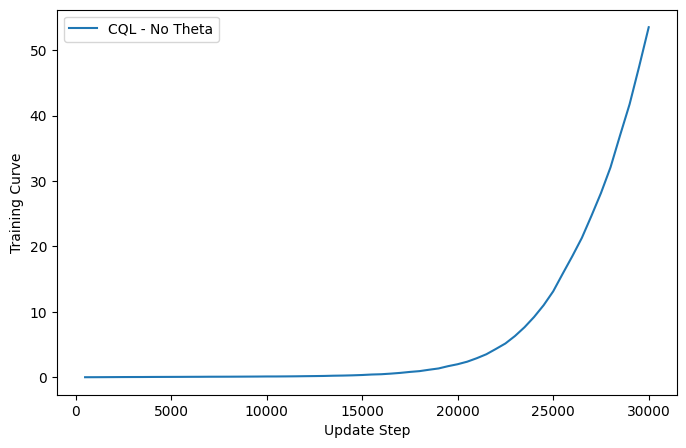

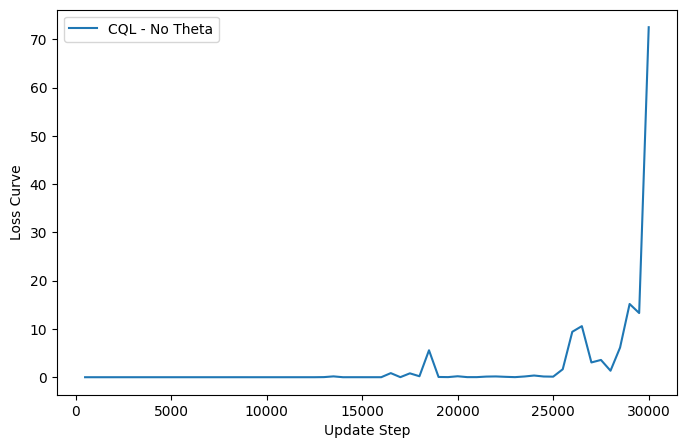

In [145]:
agent.plot(label="CQL - No Theta")